#### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image
import PIL
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "C:\Users\pkris\Anaconda3\envs\analysis\python.exe"
  * The NumPy version is: "1.21.2"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


#### Check the dimensions of an image

In [2]:
img = cv2.imread('C:/Users/pkris/Downloads/dataset/84_left.jpeg')

In [3]:
img.shape, type(img)

((1944, 2592, 3), numpy.ndarray)

#### Estimate the size of data

In [4]:
img.nbytes, img.dtype

(15116544, dtype('uint8'))

In [5]:
# Size of all images together in MB
15*500, 15*1500

(7500, 22500)

#### Check chunking of data to fit them in memory

In [6]:
import dask.array as da

In [7]:
data_dask = da.from_array(img, chunks=len(img) // 8)
data_dask

dask.array<array, shape=(1944, 2592, 3), dtype=uint8, chunksize=(243, 243, 3), chunktype=numpy.ndarray>

In [8]:
img = np.array(img,dtype='uint64')

In [9]:
img.nbytes

120932352

#### Resizing image to reduce memory requirement

In [10]:
original_path = 'C:/Users/pkris/Downloads/dataset/'
optimized_path = 'C:/Users/pkris/Downloads/compressed_dataset/'
files = [file for file in os.listdir(original_path) if file.endswith(('jpeg', 'png', 'jpg'))]
img_size = 200
for image in files:
    img = Image.open(original_path+image)
    img.thumbnail((img_size,img_size))
    img.save(optimized_path+'resized_'+image, optimize=True, quality=75)

In [10]:
original_path = 'C:/Users/pkris/Downloads/dataset/'
squared_path = 'C:/Users/pkris/Downloads/squared_dataset/'

#### Resizing to square images

In [12]:

files = [file for file in os.listdir(original_path) if file.endswith(('jpeg', 'png', 'jpg'))]
img_size = (256,256)
for image in files:
    img = Image.open(original_path+image)
    resized_img = img.resize(img_size)
    resized_img.save(squared_path+'resized_'+image)

In [13]:
img_resize.shape

(256, 256, 3)

#### Apply non-local means denoising method

In [11]:
images = []
for file in os.listdir(squared_path):
    img = cv2.imread(squared_path+'{0}'.format(file),1)   
    dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    images.append(dst)

In [12]:
len(images), images[0].shape, images[1].shape

(1427, (256, 256, 3), (256, 256, 3))

In [13]:
images_array = np.stack(images,axis=0)

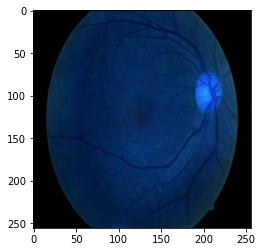

In [14]:
plt.imshow(img)

In [15]:
images_array.shape

(1427, 256, 256, 3)

In [16]:
files = [file for file in os.listdir(original_path) if file.endswith(('jpeg', 'png', 'jpg'))]

In [17]:
files[0], files[1], files[2]

('8421_right.jpeg', '8424_left.jpeg', '8424_right.jpeg')

In [18]:
squared_files = [file for file in os.listdir(squared_path) if file.endswith(('jpeg', 'png', 'jpg'))]

In [19]:
squared_files[0], squared_files[1], squared_files[2]

('resized_8421_right.jpeg',
 'resized_8424_left.jpeg',
 'resized_8424_right.jpeg')

In [20]:
df_labels = pd.read_csv('../trainLabels.csv')

In [21]:
df_labels.head()

,image,level
0,84_left,0
1,84_right,0
2,95_left,0
3,95_right,0
4,99_left,3


In [22]:
count_images = df_labels.groupby(by='level').count()

In [23]:
count_images

,image
level,
0,1016
1,113
2,230
3,32
4,36


(array([1016.,    0.,  113.,    0.,    0.,  230.,    0.,   32.,    0.,
          36.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

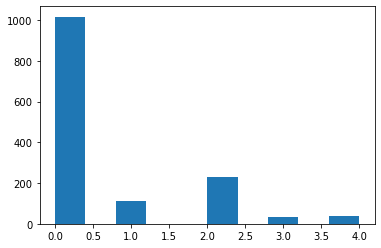

In [24]:
plt.hist(np.array([0,1,2,3,4]), weights=count_images['image'])

In [25]:
img_name = files[0].rsplit('.',1)[0]
img_name

'8421_right'

In [26]:
df_labels[df_labels['image']==img_name]

,image,level
143,8421_right,0


In [27]:
df_labels.isnull()

,image,level
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1422,False,False
1423,False,False
1424,False,False
1425,False,False


In [28]:
y_all = []
noLabelIdx = []
cnt = 0
for file in os.listdir(original_path):
    img_name = file.split('.')[0]
    label = df_labels[df_labels['image']==img_name]
    if label.empty:
        noLabelIdx.append(cnt)
        print(img_name)
    else: 
        y_all.append(label.iloc[0,1])
    cnt = cnt+1     

9999_right


In [29]:
labelIdx = np.setdiff1d(range(len(images_array)),noLabelIdx)

In [30]:
len(y_all), noLabelIdx, labelIdx[-5:]

(1426, [1424], array([1421, 1422, 1423, 1425, 1426]))

In [31]:
X_all = images_array[labelIdx,:,:,:]
y_all = np.array(y_all)

In [32]:
for i in range(5):
     globals()['indices_%slabels'% i] = [idx for idx,val in enumerate(y_all) if val==i]

In [33]:
len(indices_0labels), len(indices_1labels), len(indices_2labels), len(indices_3labels), len(indices_4labels)

(1016, 112, 230, 32, 36)

In [34]:
X_all.shape, y_all.shape

((1426, 256, 256, 3), (1426,))

In [35]:
X_all = X_all.astype('float32')

In [36]:
X_all_balanced = np.zeros((5*len(indices_0labels),256,256,3))
X_all_balanced[:len(X_all),:,:,:] = X_all
y_all_balanced = np.zeros((5*len(indices_0labels),))
y_all_balanced[:len(X_all),] = y_all

In [37]:
X_all_balanced.shape, y_all_balanced.shape

((5080, 256, 256, 3), (5080,))

In [38]:
num_rows = len(X_all)-1
X_1label = X_all[y_all==1]
y_1label = y_all[y_all==1]
for i in range(len(indices_0labels)-len(indices_1labels)):
    index = np.random.randint(0,len(indices_1labels))
    num_rows+=1
    X_all_balanced[num_rows,:,:,:] = X_1label[index,:,:,:].reshape(1,256,256,3)
    y_all_balanced[num_rows,] = y_1label[index,] 

X_2label = X_all[y_all==2]
y_2label = y_all[y_all==2]
for i in range(len(indices_0labels)-len(indices_2labels)):
    index = np.random.randint(0,len(indices_2labels))
    num_rows+=1
    X_all_balanced[num_rows,:,:,:] = X_2label[index,:,:,:].reshape(1,256,256,3)
    y_all_balanced[num_rows,] = y_2label[index,]

X_3label = X_all[y_all==3]
y_3label = y_all[y_all==3]
for i in range(len(indices_0labels)-len(indices_3labels)):
    index = np.random.randint(0,len(indices_3labels))
    num_rows+=1
    X_all_balanced[num_rows,:,:,:] = X_3label[index,:,:,:].reshape(1,256,256,3)
    y_all_balanced[num_rows,] = y_3label[index,]
    
X_4label = X_all[y_all==4]
y_4label = y_all[y_all==4]
for i in range(len(indices_0labels)-len(indices_4labels)):
    index = np.random.randint(0,len(indices_4labels))
    num_rows+=1
    X_all_balanced[num_rows,:,:,:] = X_4label[index,:,:,:].reshape(1,256,256,3)
    y_all_balanced[num_rows,] = y_4label[index,]

In [39]:
num_rows+1

5080

In [40]:
unique, counts = np.unique(y_all_balanced, return_counts=True)

In [41]:
unique, counts

(array([0., 1., 2., 3., 4.]),
 array([1016, 1016, 1016, 1016, 1016], dtype=int64))

(array([1016.,    0., 1016.,    0.,    0., 1016.,    0., 1016.,    0.,
        1016.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

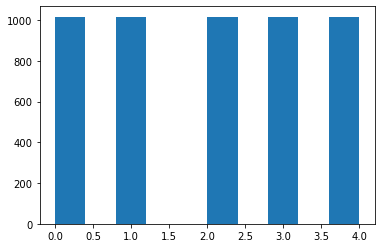

In [42]:
plt.hist(np.array([0,1,2,3,4]), weights=counts)

In [43]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
int(0.8*len(y_all_balanced)), int(0.2*len(y_all_balanced))

(4064, 1016)

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_all_balanced, y_all_balanced, test_size=0.4, \
                                                  shuffle=True, stratify=y_all_balanced)

In [47]:
np.unique(y_train), np.unique(y_val)

(array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]))

In [48]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [49]:
class_weights

array([1.00098522, 0.99934426, 0.99934426, 1.00098522, 0.99934426])

In [50]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0., 1., 2., 3., 4.]), array([609, 610, 610, 609, 610], dtype=int64))

In [51]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, \
                                                  shuffle=True, stratify=y_val)

In [52]:
ohe = OneHotEncoder()
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)
ohe.fit(y_train)
y_train_ohe = ohe.transform(y_train).toarray()
y_val_ohe = ohe.transform(y_val).toarray()
y_test_ohe = ohe.transform(y_test).toarray()

In [53]:
y_train_ohe.shape, y_val_ohe.shape, y_test_ohe.shape

((3048, 5), (1016, 5), (1016, 5))

In [54]:
np.unique(y_val), np.unique(y_test)

(array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]))

In [55]:
y_test.shape, y_val[100], y_test[100]

((1016, 1), array([1.]), array([1.]))

In [56]:
y_test_ohe.shape, y_val_ohe[100], y_test_ohe[100]

((1016, 5), array([0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0.]))

In [57]:
X_train.shape, X_val.shape, X_test.shape, y_train_ohe.shape, y_val_ohe.shape, y_test_ohe.shape

((3048, 256, 256, 3),
 (1016, 256, 256, 3),
 (1016, 256, 256, 3),
 (3048, 5),
 (1016, 5),
 (1016, 5))

In [58]:
y_train_temp = y_train.copy()
y_val_temp = y_val.copy()
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train_temp)
y_val_cat = to_categorical(y_val_temp) 

#### Augment the dataset

In [59]:
datagen1 = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.05)

In [60]:
datagen1.fit(X_train)

In [61]:
datagen2 = ImageDataGenerator(rescale=1./255,validation_split=0.05)

In [62]:
datagen2.fit(X_val)

In [63]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


from sklearn.utils import compute_class_weight
classes = np.unique(y_train)
classWeight = compute_class_weight('balanced', classes, y_train.reshape((len(y_train),))) 
weights = dict(enumerate(classWeight))

In [64]:
train_datagen = datagen1.flow(X_train, y_train_ohe, batch_size=64, subset='training', seed=42)

In [65]:
val_datagen = datagen2.flow(X_val, y_val_ohe, batch_size=32, subset='validation', seed=42)

In [66]:
def train_gen():
    datagen1 = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.05)
    datagen1.fit(X_train)
    train_datagen = datagen1.flow(X_train, y_train_ohe, batch_size=64, subset='training', seed=42)
    return train_datagen

def val_gen():
    datagen2 = ImageDataGenerator(rescale=1./255,validation_split=0.05)
    datagen2.fit(X_val)
    val_datagen = datagen2.flow(X_val, y_val_ohe, batch_size=32, subset='validation', seed=42)
    return val_datagen

In [67]:
from keras_tuner.tuners import RandomSearch

In [68]:
def cnn_model(hp):
    model = tf.keras.Sequential()
    input_shape = (256,256,3)
    units = hp.Choice('num_units', values=[64,128,256,512])
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), \
                                     kernel_initializer='glorot_normal', \
                                     input_shape=input_shape, use_bias=True))  
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(tf.keras.layers.Activation('relu'))
    
    for i in range(hp.Int('layers', 1, 6)):
        model.add(tf.keras.layers.Conv2D(filters=units, \
                 kernel_size=(3,3), strides=(1,1), kernel_initializer='glorot_normal', use_bias=True))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
        model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('layers', 1, 6)):
        model.add(tf.keras.layers.Dense(units=units, activation='relu', kernel_initializer='glorot_normal', use_bias=True))
    model.add(tf.keras.layers.Dense(5, activation='softmax', use_bias=True))
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', values=[0.01,0.001,0.0001,0.00001]), beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

class ClearTrainingOutputs(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [69]:
tuner = RandomSearch(
    hypermodel=cnn_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


In [ ]:
tuner.search(train_gen(), epochs=5, validation_data=val_gen(), \
             callbacks=[ClearTrainingOutputs()], workers=4)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_units         |64                |?                 
layers            |6                 |?                 
lr                |0.001             |?                 

Epoch 1/5


In [178]:
with mirrored_strategy.scope():
    model = tf.keras.Sequential()
    input_shape = (256,256,3)
    filters = hp.Choice('num_filters', values=[64,128,256,512])
    
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), \
                                     kernel_initializer='glorot_normal', \
                                     input_shape=input_shape, use_bias=True))  
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), \
                                     kernel_initializer='glorot_normal', \
                                     #kernel_regularizer=tf.keras.regularizers.l2(l2=0.001), \
                                     use_bias=True))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(tf.keras.layers.Activation('relu'))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), \
                                     kernel_initializer='glorot_normal', \
                                     #kernel_regularizer=tf.keras.regularizers.l2(l2=0.001), \
                                     use_bias=True))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(tf.keras.layers.Activation('relu'))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), \
                                     kernel_initializer='glorot_normal', \
                                     #kernel_regularizer=tf.keras.regularizers.l2(l2=0.001), \
                                     use_bias=True))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_normal', use_bias=True))  
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_normal', use_bias=True))    
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_normal', use_bias=True))   
    model.add(tf.keras.layers.Dense(5, activation='softmax', use_bias=True))

In [179]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 253, 253, 64)      0         
_________________________________________________________________
activation_53 (Activation)   (None, 253, 253, 64)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 251, 251, 64)      36928     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 250, 250, 64)      0         
_________________________________________________________________
activation_54 (Activation)   (None, 250, 250, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 248, 248, 128)   

In [180]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta

In [181]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
#opt = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0)

In [182]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [183]:
num_epochs = 50

In [184]:
len(X_train)//64, len(X_val)//64

(47, 15)

In [ ]:
history = model.fit(train_datagen, epochs=num_epochs, \
                   validation_data=val_datagen, workers=4)
#history = model.fit(x=X_train, y=y_train_ohe, steps_per_epoch=len(X_train)//64, epochs=num_epochs, \
#                   validation_data=(X_val,y_val_ohe), validation_steps=len(X_val)//32, workers=4)

Epoch 1/50


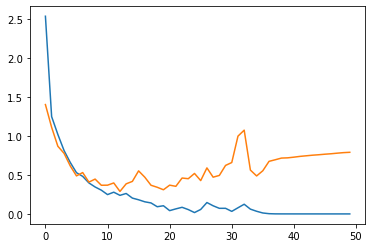

In [122]:
plt.plot(range(num_epochs), history.history['loss'])
plt.plot(range(num_epochs), history.history['val_loss'])

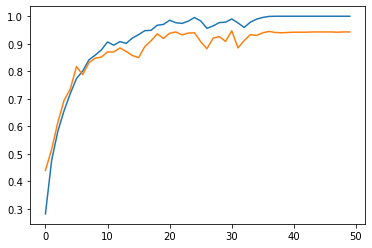

In [123]:
plt.plot(range(num_epochs), history.history['accuracy'])
plt.plot(range(num_epochs), history.history['val_accuracy'])

In [164]:
np.unique(y_train), np.unique(y_val)

(array([0, 1, 2, 3, 4], dtype=int64), array([0, 1, 2, 3, 4], dtype=int64))

In [176]:
np.unique(y_valPred)

array([0], dtype=int64)